In [1]:
import sys
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sys.path.append('../lib')
from local_paths import mplstyle_path, preproc_dir

In [2]:
plt.style.use(mplstyle_path)

In [3]:
preproc_dir = Path(preproc_dir).expanduser()

# Main

In [4]:
fix_dfs = []
sess_names = []

for fp in sorted(preproc_dir.glob('*-proc.h5')):
    fix_df = pd.read_hdf(fp, 'fixation_dataframe', 'r')
    fix_df.sort_index(inplace=True)
    fix_dfs.append(fix_df)
    sess_names.append(fp.stem.replace('-proc', ''))

In [5]:
sum_sacc_df = []
for sess_name, fix_df in zip(sess_names, fix_dfs):
    # get saccade info out of fix df via consecutive fixations

    iprevs = fix_df['Preceding fixation index'].values
    m = iprevs != -1
    if not m.any(): continue
    iprevs = iprevs[m]
    icurrs = np.nonzero(m)[0]
    df_ = pd.DataFrame(data={
        'Duration': fix_df.iloc[icurrs]['Trial time'].values - fix_df.iloc[iprevs][['Trial time', 'Duration']].values.sum(1),
        'Size': np.linalg.norm(fix_df.iloc[icurrs][['Relative X', 'Relative Y']].values - fix_df.iloc[iprevs][['Relative X', 'Relative Y']].values, axis=1)
    })
    df_['Subject'] = sess_name[:2]
    sum_sacc_df.append(df_)

sum_sacc_df = pd.concat(sum_sacc_df)

In [6]:
sum_fix_df = []
for sess_name, df_ in zip(sess_names, fix_dfs):
    df_ = df_[['Time', 'Duration']]

    # remove first fixations of a trial because these are clipped to stim onset
    tr_fix_first = list(df_.index[df_.index.get_level_values(1)==0])
    df_ = df_.drop(index=tr_fix_first)

    df_['Subject'] = sess_name[:2]
    sum_fix_df.append(df_)

sum_fix_df = pd.concat(sum_fix_df)

In [7]:
df_ = sum_fix_df.reset_index(drop=True)[['Subject', 'Duration']]
df_.groupby('Subject').mean().agg(['mean', 'std', 'median'])

,Duration
mean,275.828331
std,48.532969
median,277.432701


In [8]:
df_ = sum_sacc_df.reset_index(drop=True)[['Subject', 'Duration', 'Size']]
df_.groupby('Subject').mean().agg(['mean', 'std', 'median'])

,Duration,Size
mean,49.713095,5.415753
std,4.690731,0.932921
median,48.196239,5.125150


In [9]:
bins_dict = {
    'Fixation duration': np.arange(0, 626, 25) - 12.5,
    'Saccade duration': np.arange(25, 86, 5) - 2.5,
    'Saccade size': np.arange(0, 13.5, 1) - 0.5}

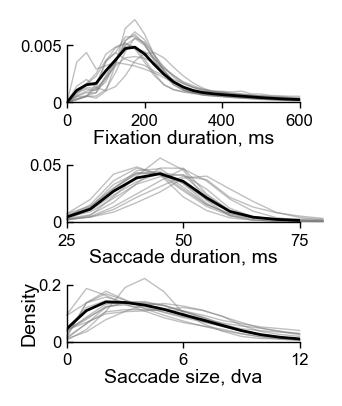

In [10]:
fig, axs = plt.subplots(3, 1, figsize=(1.5,2))
plt.subplots_adjust(hspace=0.75)
usubjs = np.unique(sum_fix_df['Subject'].values)

for i, (df_, x, x2, ax) in enumerate(zip(
        (sum_fix_df, sum_sacc_df, sum_sacc_df),
        ('Duration', 'Duration', 'Size'),
        ('Fixation duration', 'Saccade duration', 'Saccade size'),
        axs)):
    v = df_[x].values

    # clip outliers: outside ~95-th percentile
    xl = np.nanpercentile(v, [2.5, 97.5])
    xl += xl.ptp() * np.array([-1, 1]) * .1
    xl[0] = max(0, xl[0])
    m = (v>=xl[0])&(v<=xl[1])
    df_ = df_[m]

    kws = dict(
        ax=ax, stat='density', common_norm=False,
        bins=bins_dict[x2],
        element='poly', fill=False, legend=False)

    sns.histplot(
        data=df_, x=x, hue='Subject',
        palette=['gray']*len(usubjs), clip_on=False,
        linewidth=.5, alpha=0.5, **kws)
    sns.histplot(
        data=df_, x=x, color='k', **kws)

    ax.set_xlim(xl)

    ytk = ax.get_yticks()
    ytk = [0, ytk[1]]
    ax.set_ylim([ytk[0], ytk[1]+np.ptp(ytk)*.2])
    ax.set_yticks(ytk)
    ax.set_yticklabels([0, str(ytk[1])])
    ax.spines['left'].set_bounds(ytk)
    ax.tick_params(axis='y', direction='in')

    if i == 2:
        ax.set_ylabel('Density')
        tfm = mpl.transforms.blended_transform_factory(ax.transAxes, ax.transData)
        ax.yaxis.set_label_coords(-.125, np.mean(ytk), transform=tfm)
    else:
        ax.set_ylabel('')

axs[0].set_xlabel('Fixation duration, ms', labelpad=0)
axs[1].set_xlabel('Saccade duration, ms', labelpad=0)
axs[2].set_xlabel('Saccade size, dva', labelpad=0)

axs[0].set_xlim(0, 600)
axs[0].set_xticks([0, 200, 400, 600])
axs[0].spines['bottom'].set_bounds(0, 600)
axs[1].set_xlim(25, 75)
axs[1].set_xticks([25, 50, 75])
axs[1].spines['bottom'].set_bounds(25, 75)
axs[2].set_xlim(0, 12)
axs[2].set_xticks([0, 6, 12])
axs[2].spines['bottom'].set_bounds(0, 12)

plt.savefig('plots/fig1cde.png')